# About data_connector

This notebook pulls information from different sources of data (log, session) to connect student's data across types.
The end goal is a connection between student id and log files, survey data, and worksheet data.

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
import matplotlib.pyplot as plt
#utils.py is where all our custorm functions live is we set an autoreload on it.
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing 
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 20, 7
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)

## Overview
We have log data, survey data, worksheet data and lots of metadata. We have to connect them all! First we must build the right metadata files.
Let's start by connecting log data files to session data, mapping each log data to a student and to a session using dates and times.

## 1. Connecting log data to session data
We grab the parsing file reports and the session data

In [2]:
df_beers = get_latest_parsing_report('beers')
df_beers = df_beers[df_beers.studentid != 'student1']
df_beers.studentid = df_beers.studentid.astype(int)
df_caps = get_latest_parsing_report('capacitor')
df_caps.studentid = df_caps.studentid.astype(int)
df_sessions = get_session_data()

Captured beers parsing report that was parsed on 2017-11-09_09.25.32
Captured capacitor parsing report that was parsed on 2017-11-08_14.55.27


In [3]:
df_sessions

,session number,date,number of students from sign out sheet,start time,end time,wave,ran study,supported,keep
0,1,2017-1-13,5,13,15,1,Jon,Sarah,drop
1,2,2017-1-17,14,11,13,1,Jon,Sarah,keep
2,3,2017-1-17,18,15,17,1,Sarah,Jon,keep
3,4,2017-1-19,5,9,11,1,Sarah,Jon,keep
4,5,2017-1-19,18,13,15,1,Jon,Sarah,keep
5,6,2017-1-20,10,11,13,1,Sarah,Jon,keep
6,7,2017-1-20,18,15,17,1,Jon,Sarah,keep
7,8,2017-1-23,7,15,17,1,Sarah,Jon,keep
8,9,2017-1-27,12,13,15,1,Sarah,Jon,keep
9,10,2017-3-20,15,15,17,2,Sarah,Jon,keep


In [4]:
def get_session_times(df):
    times = {}
    for i,row in df.iterrows():
        day,start,end,session = row['date'],str(row['start time']),str(row['end time']),int(row['session number'])
        date = (day+'_'+start+".00.00",day+'_'+end+".00.00")
        times[session]=date
    return times
session_times = get_session_times(df_sessions)
print session_times

{1: ('2017-1-13_13.00.00', '2017-1-13_15.00.00'), 2: ('2017-1-17_11.00.00', '2017-1-17_13.00.00'), 3: ('2017-1-17_15.00.00', '2017-1-17_17.00.00'), 4: ('2017-1-19_9.00.00', '2017-1-19_11.00.00'), 5: ('2017-1-19_13.00.00', '2017-1-19_15.00.00'), 6: ('2017-1-20_11.00.00', '2017-1-20_13.00.00'), 7: ('2017-1-20_15.00.00', '2017-1-20_17.00.00'), 8: ('2017-1-23_15.00.00', '2017-1-23_17.00.00'), 9: ('2017-1-27_13.00.00', '2017-1-27_15.00.00'), 10: ('2017-3-20_15.00.00', '2017-3-20_17.00.00'), 11: ('2017-3-21_17.00.00', '2017-3-21_19.00.00'), 12: ('2017-3-22_11.00.00', '2017-3-22_13.00.00'), 13: ('2017-3-22_15.00.00', '2017-3-22_17.00.00'), 14: ('2017-3-23_13.00.00', '2017-3-23_15.00.00'), 15: ('2017-3-28_15.00.00', '2017-3-28_17.00.00')}


In [5]:
def convert_from_unix_time(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%Y-%m-%d_%H.%M.%S')

def convert_to_unix_time(date):
    ''' Take a date and time amd make a unix time stamp'''
    return datetime.datetime.strptime(date, '%Y-%m-%d_%H.%M.%S')

def convert_from_unix_time_plot(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%m-%d_%H')

def extrapolate_session(row):
    session = 'NA'
    date = row['date']
    timestamp = convert_to_unix_time(date)
    for session_number,period in session_times.iteritems():
        t1,t2 = convert_to_unix_time(period[0]),convert_to_unix_time(period[1])
        if timestamp > t1 and timestamp < t2:
            session = session_number   
    return session

df_beers['Session'] = df_beers.apply(extrapolate_session, axis=1)
df_caps['Session'] = df_caps.apply(extrapolate_session, axis=1)

In [6]:
def get_ids_per_session(df):
    ids_per_session = {s:[] for s in set(df['Session'])}
    for i,row in df.iterrows():
        sid,session = str(row['studentid']),row['Session']
        ids_per_session[session].append(sid)
    return ids_per_session

session_beers = get_ids_per_session(df_beers)
session_caps = get_ids_per_session(df_caps)

In [7]:
out =open('session_mega_id_writeout.txt','w')
out.write('\t'.join(['Session','Session time','Expected number (signout sheet)','sim','number of logs','ids']))
for session in sorted(session_times.keys()):
    if session != 'NA':
        expected = str(int(df_sessions[df_sessions['session number']==session]['number of students from sign out sheet']))
    else:
        expected = 'NA'
    period = str(session_times[session][0])+' - '+str(session_times[session][1])
    out.write('\n')
    out.write('\t'.join([str(session),period,expected,'beers',str(len(session_beers[session])), '\t'.join(sorted(session_beers[session]))]))
    out.write('\n')
    out.write('\t'.join(['','','','caps',str(len(session_caps[session])), '\t'.join(sorted(session_caps[session]))]))
    out.write('\n')
out.close()

In [8]:
df_beers.head()

,studentid,sim,date,first time stamp,time in PhET,number of user events,number of model events,number of table errors,number of records,number of gettingValues,number of restores,use table,use graph,use notepad,filename,Session
0,10105157,beers-law-lab,2017-03-22_11.41.17,1490208079592,740.21,2279,988,0,11,11,0,True,True,True,C:\Users\Sarah\Documents\Personal Content\Lab_...,12
1,10127163,beers-law-lab,2017-01-27_13.26.59,1485552421644,971.09,3097,2114,0,23,0,0,True,True,False,C:\Users\Sarah\Documents\Personal Content\Lab_...,9
2,10192168,beers-law-lab,2017-01-20_16.22.58,1484958181216,458.90,3443,1824,0,27,0,0,True,True,False,C:\Users\Sarah\Documents\Personal Content\Lab_...,7
3,10232160,beers-law-lab,2017-01-20_15.24.45,1484954687669,811.30,4468,2253,0,8,0,0,True,True,False,C:\Users\Sarah\Documents\Personal Content\Lab_...,7
4,10375163,beers-law-lab,2017-01-17_16.21.15,1484698878197,602.05,1476,817,0,15,0,0,True,True,False,C:\Users\Sarah\Documents\Personal Content\Lab_...,3


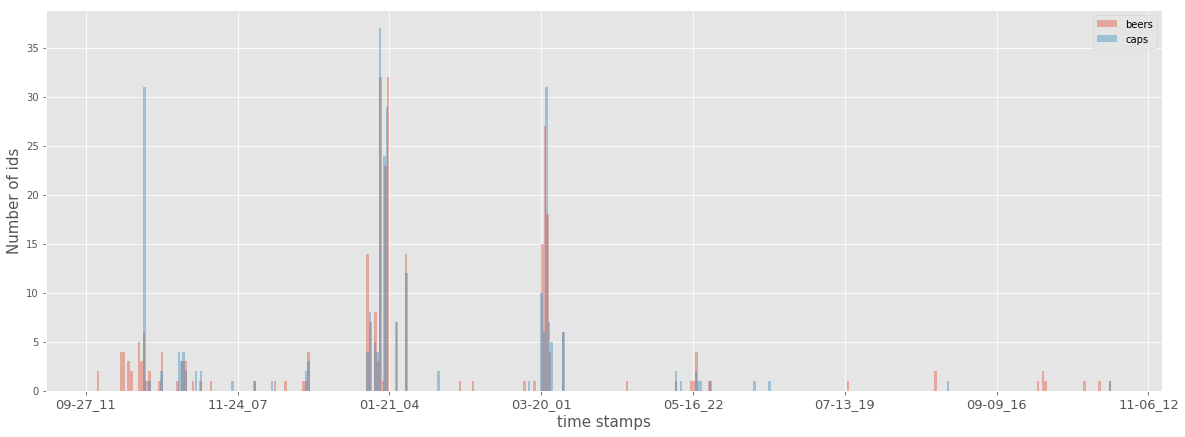

In [9]:
df_beers['first time stamp'].hist(bins=395,alpha=0.4,label='beers')
df_caps['first time stamp'].hist(bins=395,alpha=0.4,label='caps') #about 1 bin per day
# df_sessions['first time stamp'].hist(bins=50,alpha=0.6,label='caps')
ax = plt.subplot()
ax.legend();ax.set_xlabel('time stamps',fontsize=15);ax.set_ylabel('Number of ids',fontsize=15)
xticks = ax.get_xticks()
ax.set_xticklabels([convert_from_unix_time_plot(x) for x in xticks],fontsize=13)

In [10]:
print set(df_beers[df_beers['Session']=='NA']['studentid'])
print set(df_caps[df_caps['Session']=='NA']['studentid'])

set([12357888, 12344675, 11111111, 12345678, 12341234, 12345667, 12344564, 12344567, 78379161, 14444703, 12345567])
set([12456456, 78379161, 99999999, 12345678, 11111111])


## 2. Find all logs per id
Now that we know what session each id is from, we can start documenting log file pairs to student ids. From the file "*session_mega_id_writeout.xlsx*" it's apparent that some student have several log files. We want to keep track of these to help with log data analysis later.
Ultimately we want a mega metadatafile with the following columns:
* student id
* session
* use in analysis - binary
* id in pre
* id in worksheet
* number of beers files
* number of caps files
* date beers 1
* date beers 2
* date beers 3
* date caps 1
* date caps 2
* date caps 3
* comments/issues

Some columns will be filled using information from the document "*running study and analytics thoughts.gdoc*"

In [16]:
ids = list(set(df_beers.studentid).union(set(df_caps.studentid)))
# ids = [11669161,12345678]
# header = ["session","use in analysis","id in pre","id in worksheet","number of beers files","number of caps files","date beers 1","date beers 2","date beers 3","date caps 1","date caps 2","date caps 3","comments/issues"]
# initializing = {'student id':ids}
# initializing.update({h:None for h in header})
meta_df = pd.DataFrame(index =ids)
# meta_df.set_index('student id')
meta_df.head()

""
11612162
13660166
41947147
64006159
15749160


In [17]:
for i,studentid in enumerate(ids):
    session = np.nan
    try:
        b_logs = df_beers[df_beers["studentid"]==studentid]
        c_logs = df_caps[df_caps["studentid"]==studentid]
        b_sessions = b_logs['Session'].values
        c_sessions = c_logs['Session'].values
        error = np.nan
        n_beers = len(b_sessions)
        n_caps = len(c_sessions)
        b_date_1, b_events_1 = b_logs['date'].values[0], b_logs['number of user events'].values[0]
        c_date_1, c_events_1 = c_logs['date'].values[0], c_logs['number of user events'].values[0]
        b_date_2, b_events_2 = np.nan, np.nan
        b_date_3, b_events_3 = np.nan, np.nan
        c_date_2, c_events_2 = np.nan, np.nan
        c_date_3, c_events_3 = np.nan, np.nan

        #determine all logs belong to a session
        if 'NA' not in b_sessions and 'NA' not in c_sessions:
            #determine if there are at least 1 logs per sim
            if len(b_sessions)>=1 and len(c_sessions)>=1:
                #determine if all logs from same session
                if len(set(b_sessions).union(set(c_sessions))) == 1:
                    use_analysis = True
                    session = b_sessions[0]
                    if n_caps >1 :
                        c_logs = c_logs.sort_values('date')
                        c_dates = c_logs['date'].values
                        c_number_events = c_logs['number of user events'].values
                        if n_caps == 2:
                            c_date_1, c_events_1 = c_logs['date'].values[0], c_logs['number of user events'].values[0]
                            c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                            c_date_3, c_events_3 = 'NA', 'NA'
                        elif n_caps == 3:
                            c_date_1, c_events_1 = c_logs['date'].values[0],c_logs['number of user events'].values[0]
                            c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                            c_date_3, c_events_3 = c_logs['date'].values[2],c_logs['number of user events'].values[2]
                        else:
                            error = "ERROR: more than 3 log files"
            #                 print c_logs
                    else:
                        c_date_1 = c_logs['date'].values[0]
                        c_date_2, c_events_2 = 'NA', 'NA'
                        c_date_3, c_events_3 = 'NA', 'NA'


                    if n_beers >1 :
                        b_logs = b_logs.sort_values('date')
                        b_dates = b_logs['date'].values
                        b_number_events = b_logs['number of user events'].values
                        if n_beers == 2:
                            b_date_1, b_events_1 = b_logs['date'].values[0], b_logs['number of user events'].values[0]
                            b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                            b_date_3, b_events_3 = 'NA', 'NA'
                        elif n_beers == 3:
                            b_date_1, b_events_1 = b_logs['date'].values[0],b_logs['number of user events'].values[0]
                            b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                            b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                        else:
                            error = "ERROR: more than 3 log files"
            #                 print b_logs
                    else:
                        b_date_1 = b_logs['date'].values[0]
                        b_date_2, b_events_2 = 'NA', 'NA'
                        b_date_3, b_events_3 = 'NA', 'NA'

                else:
                    error = "ERROR: student participated in more than 1 session?"
                    use_analysis = False
            else:
                error = "ERROR: student doesn't have logs in both sims"
                use_analysis = False
        elif len(set(b_sessions).union(set(c_sessions))) > 1: #ie there are NAs and non NA sessions
            error = "ERROR: student has logs within and outside of sessions?"
            use_analysis = False
        else: #all logs are outside of a session
            use_analysis = False

    #     print c_date_1, c_date_2, c_date_3
    #     print c_events_1, c_events_2, c_events_3
        meta_df.set_value(studentid, 'session', session)
        meta_df.set_value(studentid, 'use analysis', use_analysis)
        meta_df.set_value(studentid, 'number of caps sessions', n_caps)
        meta_df.set_value(studentid, 'number of beers sessions', n_beers)
        meta_df.set_value(studentid, 'date caps 1', c_date_1)
        meta_df.set_value(studentid, 'date caps 2', c_date_2)
        meta_df.set_value(studentid, 'date caps 3', c_date_3)
        meta_df.set_value(studentid, 'events caps 1', c_events_1)
        meta_df.set_value(studentid, 'events caps 2', c_events_2)
        meta_df.set_value(studentid, 'events caps 3', c_events_3)
        meta_df.set_value(studentid, 'date beers 1', b_date_1)
        meta_df.set_value(studentid, 'date beers 2', b_date_2)
        meta_df.set_value(studentid, 'date beers 3', b_date_3)
        meta_df.set_value(studentid, 'events beers 1', b_events_1)
        meta_df.set_value(studentid, 'events beers 2', b_events_2)
        meta_df.set_value(studentid, 'events beers 3', b_events_3)
        meta_df.set_value(studentid, 'comments', error)
    except:
        print "failed:",studentid

failed: 12345567
failed: 12344564
failed: 12344567
failed: 99999999
failed: 12357888
failed: 12345667
failed: 12344675
failed: 31607164
failed: 10866146
failed: 12456456
failed: 36107164
failed: 13493169
failed: 14444703
failed: 12341234


In [18]:
meta_df

,session,use analysis,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,events beers 1,events beers 2,events beers 3,comments
11612162,2.0,True,1.0,1.0,2017-01-17_11.22.57,NA,NA,1917.0,NA,NA,2017-01-17_12.17.50,NA,NA,1484.0,NA,NA,NaN
13660166,15.0,True,1.0,1.0,2017-03-28_16.20.11,NA,NA,3642.0,NA,NA,2017-03-28_15.28.56,NA,NA,3228.0,NA,NA,NaN
41947147,2.0,True,1.0,1.0,2017-01-17_11.22.57,NA,NA,4162.0,NA,NA,2017-01-17_12.17.51,NA,NA,3678.0,NA,NA,NaN
64006159,2.0,True,1.0,1.0,2017-01-17_12.17.34,NA,NA,1185.0,NA,NA,2017-01-17_11.22.34,NA,NA,2218.0,NA,NA,NaN
15749160,14.0,True,2.0,1.0,2017-03-23_13.17.23,2017-03-23_13.25.52,NA,0.0,4019,NA,2017-03-23_14.25.38,NA,NA,2298.0,NA,NA,NaN
16901162,11.0,True,1.0,1.0,2017-03-21_17.27.09,NA,NA,1619.0,NA,NA,2017-03-21_18.25.03,NA,NA,2374.0,NA,NA,NaN
51717164,3.0,True,1.0,1.0,2017-01-17_15.22.53,NA,NA,1761.0,NA,NA,2017-01-17_16.21.04,NA,NA,3397.0,NA,NA,NaN
10970160,8.0,True,1.0,1.0,2017-01-23_16.21.03,NA,NA,4613.0,NA,NA,2017-01-23_15.24.13,NA,NA,5414.0,NA,NA,NaN
17114169,7.0,True,1.0,1.0,2017-01-20_16.23.09,NA,NA,4389.0,NA,NA,2017-01-20_15.24.55,NA,NA,3701.0,NA,NA,NaN
17071167,5.0,True,1.0,1.0,2017-01-19_14.21.48,NA,NA,3253.0,NA,NA,2017-01-19_13.26.00,NA,NA,4899.0,NA,NA,NaN


In [21]:
meta_df.groupby("use analysis").sum()

,session,number of caps sessions,number of beers sessions,events caps 1,events beers 1,comments
use analysis,,,,,,
False,NaN,74.0,100.0,292.0,2300.0,NaN
True,1230.0,170.0,178.0,423447.0,549303.0,NaN
